In [1]:
import scanpy as sc
import pandas as pd
import diffxpy.api as de
import numpy as np
import patsy
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
import upsetplot as usp
from matplotlib import rcParams
from diffxpy.testing.det import DifferentialExpressionTestWald
import matplotlib.cm as cm
import matplotlib as mpl
from sklearn.preprocessing import minmax_scale
from anndata import AnnData
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy import sparse
from diffxpy.testing.det import DifferentialExpressionTestWald

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/data_exploration/')
import helper_diffxpy as hde
import importlib
importlib.reload(hde)
import helper_diffxpy as hde
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
import importlib
importlib.reload(h)
import helper as h

In [11]:
# Set Path variables to call when needed
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_full='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_de='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/de/de_sexaging_covarSample/''

In [4]:
# Load the needed data 
adata_b_rn=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')

## Prepare data

Subset data

In [5]:
# Samples which should be analysed 
studies=['Fltp_2y']
samples=adata_b_rn.obs.query('study in @studies').study_sample.unique().tolist()
print('N samples to use',len(samples))
print(samples)

N samples to use 3
['Fltp_2y_MUC13976', 'Fltp_2y_MUC13975', 'Fltp_2y_MUC13974']


In [6]:
# Subset 
# Samples
adata_b_rn_sub=adata_b_rn[adata_b_rn.obs.study_sample.isin(samples),:].copy()
# Clusters
adata_b_rn_sub=adata_b_rn_sub[ ~adata_b_rn_sub.obs['leiden_r1.5'].isin(['19','20']),:].copy()
print(adata_b_rn_sub.shape)
print(adata_b_rn_sub.obs.study_sample_design.unique().tolist())
print(adata_b_rn_sub.obs['leiden_r1.5'].unique().tolist())

(14253, 30672)
['Fltp_2y_MUC13976_mGFP', 'Fltp_2y_MUC13975_mTmG', 'Fltp_2y_MUC13974_mRFP']
['2', '5', '22', '18', '17', '9', '3', '13', '10', '1', '12', '15', '8', '7', '6', '4', '14', '11', '16', '21', '0']


Plot data

In [7]:
# Compute a neighborhood graph of observations and the umap
sc.pp.neighbors(adata_b_rn_sub,n_pcs=0,use_rep='X_integrated')
sc.tl.umap(adata_b_rn_sub)

Trying to set attribute `._uns` of view, copying.


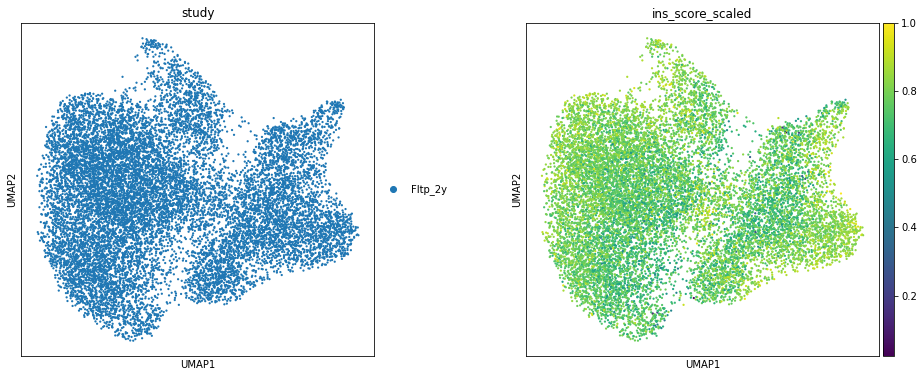

In [8]:
# Plot umap for adata.obs study and ins_score_scaled
rcParams['figure.figsize']=(6,6)
random_indices=np.random.permutation(list(range(adata_b_rn_sub.shape[0])))
sc.pl.umap(adata_b_rn_sub[random_indices,:],
           color=['study','ins_score_scaled'],s=20,sort_order=False,wspace=0.3)

Trying to set attribute `._uns` of view, copying.


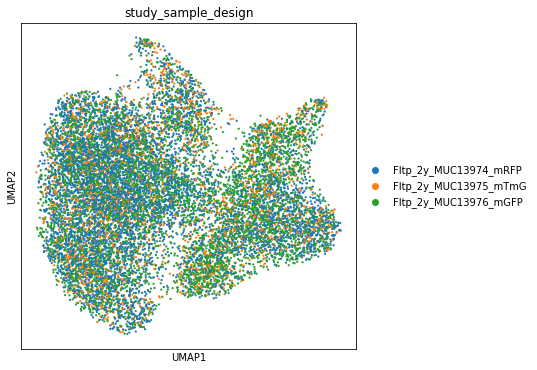

In [9]:
# Plot umap for adata.obs study_sample_design, to see the different samples
rcParams['figure.figsize']=(6,6)
random_indices=np.random.permutation(list(range(adata_b_rn_sub.shape[0])))
sc.pl.umap(adata_b_rn_sub[random_indices,:],
           color=['study_sample_design'],s=20,sort_order=False,wspace=0.3)

## DE test

DE data

In [7]:
# Get raw expression data for DE testing, subsetting by cells
adata_b_raw_sub=sc.read( path_data+'data_integrated_analysed_beta_v1s1.h5ad'
    ).raw.to_adata()[ adata_b_rn_sub.obs_names,:].copy()
print(adata_b_raw_sub.shape)

(14253, 30672)


In [8]:
# Add the new obs 'sex_female' to adata with female = 1 and male = 0
adata_b_rn_sub.obs['sex_num']=adata_b_rn_sub.obs.sex.replace(['female', 'male'], [1, 0])

In [9]:
# Add needed obs for DE
adata_b_raw_sub.obs=pd.concat( [adata_b_rn_sub.obs['size_factors_integrated'], 
                                adata_b_rn_sub.obs['sex'], 
                                adata_b_rn_sub.obs['age'],
                                adata_b_rn_sub.obs['sex_num'],
                                adata_b_raw_sub.obs['file']],axis=1)

Expression filtering

In [13]:
# Set the minimun cell ratio:
min_cells_ratio=0.05

In [14]:
# prepare adata
# Data for testing
adata=adata_b_raw_sub.copy()
# Select expressed genes in partition
min_cells=adata.shape[0]*min_cells_ratio
print('Min cells: %.1f'% min_cells)
expressed=np.array((adata.X.todense()!=0).sum(axis=0)>=min_cells)[0]
adata=adata[:,expressed]
print('Data after expression filtering:',adata.shape)

Min cells: 712.7
Data after expression filtering: (14253, 10520)


Ambient removal

In [15]:
# Remove all ambient genes (from all studies)
ambient_nobeta=pickle.load(open('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/ambient/ambient_nonbeta.pkl'
    ,'rb'))['ambient_nonbeta']
print('N ambient genes:',len(ambient_nobeta))
adata=adata[:,[g for g in adata.var_names 
                                   if g not in ambient_nobeta]]
print('Data after ambient filtering:',adata.shape)

N ambient genes: 367
Data after ambient filtering: (14253, 10259)


Design-Matrix

In [16]:
# Create a design Matrix

dmat_loc=pd.DataFrame(index=adata.obs_names)
dmat_loc['Intercept']=1

# process of interest
process='sex_num'
dmat_loc[process]=adata.obs[process]

# Add files, these are the samples
# 3 samples, one is in intercept
dmat_loc['MUC13975']=adata_b_rn_sub.obs.file.replace(['MUC13974', 'MUC13975', 'MUC13976'], [0, 1, 0])
dmat_loc['MUC13976']=adata_b_rn_sub.obs.file.replace(['MUC13974', 'MUC13975', 'MUC13976'], [0, 0, 1])
    
dmat_loc.fillna(0,inplace=True)
dmat_loc=dmat_loc.astype('float')

print('dmat_loc')
display(dmat_loc)

dmat_scale=pd.DataFrame(dmat_loc['Intercept'])
constraints_scale=None
constraints_loc=None

sex_female=process

dmat_loc


Intercept  sex_num  MUC13975  MUC13976
AAACCCAAGTTCTCTT-1-MUC13976-Fltp_2y        1.0      0.0       0.0       1.0
AAACCCACACAGTACT-1-MUC13976-Fltp_2y        1.0      1.0       0.0       1.0
AAACCCAGTCATAGTC-1-MUC13976-Fltp_2y        1.0      1.0       0.0       1.0
AAACCCAGTTATCCAG-1-MUC13976-Fltp_2y        1.0      1.0       0.0       1.0
AAACCCATCACCCTCA-1-MUC13976-Fltp_2y        1.0      1.0       0.0       1.0
...                                        ...      ...       ...       ...
TTTGTTGAGGCTCTCG-1-MUC13974-Fltp_2y        1.0      1.0       0.0       0.0
TTTGTTGAGGTCCAGA-1-MUC13974-Fltp_2y        1.0      0.0       0.0       0.0
TTTGTTGGTAGCGATG-1-MUC13974-Fltp_2y        1.0      1.0       0.0       0.0
TTTGTTGGTCAAAGTA-1-MUC13974-Fltp_2y        1.0      1.0       0.0       0.0
TTTGTTGGTTCTTGCC-1-MUC13974-Fltp_2y        1.0      1.0       0.0       0.0

[14253 rows x 4 columns]

In [17]:
# Create dense adata, so that the Waldtest can work
if sparse.issparse(adata.X):
        new_adata = sc.AnnData(X=adata.X.A, obs=adata.obs.copy(deep=True), var=adata.var.copy(deep=True), uns=adata.uns.copy(), obsm=adata.obsm.copy())

In [18]:
# Perform the Wald test
if True:
    # Compute result
    result=de.test.wald(
        data=new_adata,
        coef_to_test=sex_female,
        dmat_loc=dmat_loc,
        dmat_scale=dmat_scale,
        # Use integarted sf
        size_factors=new_adata.obs.size_factors_integrated,
        )

    # Add design info to result
    result.dmat_loc=dmat_loc
    result.dmat_scale=dmat_scale
    result.coef_loc_totest_name=sex_female

    # save result
    pickle.dump(result, 
        open(path_de+'maleFemale_Fltp_2y_'+str(min_cells_ratio)+'.pkl', 
                     "wb" ))

/home/icb/k.noerenberg/miniconda3/envs/data_analyticBSC/batchglm/batchglm/models/base_glm/utils.py:158: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  np.mean(x[np.where(grouping == g)[0], :], axis=0)
/home/icb/k.noerenberg/miniconda3/envs/data_analyticBSC/batchglm/batchglm/models/base_glm/utils.py:171: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
   

training location model: True
training scale model: True
iter   0: ll=20539351057.688290
caught 1 linalg singular matrix errors
iter   1: ll=20523297818.610783, converged: 0.00% (loc: 92.10%, scale update: False), in 11.63sec
iter   2: ll=20519712151.500851, converged: 0.00% (loc: 92.10%, scale update: False), in 2.98sec
iter   3: ll=20519422434.611488, converged: 0.00% (loc: 92.10%, scale update: False), in 3.22sec
iter   4: ll=20519416880.971985, converged: 0.00% (loc: 92.10%, scale update: False), in 2.98sec
iter   5: ll=20519416845.143013, converged: 0.00% (loc: 92.11%, scale update: False), in 3.10sec
iter   6: ll=168677994.323437, converged: 0.00% (loc: 0.00%, scale update: True), in 135.39sec
caught 1 linalg singular matrix errors
iter   7: ll=154780958.269436, converged: 0.00% (loc: 0.98%, scale update: False), in 11.27sec
iter   8: ll=151491897.609385, converged: 0.00% (loc: 2.15%, scale update: False), in 10.32sec
iter   9: ll=151271181.685456, converged: 0.00% (loc: 4.32%, s

/home/icb/k.noerenberg/miniconda3/envs/data_analyticBSC/lib/python3.9/site-packages/dask/array/core.py:2975: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


## Analyse DE data

In [19]:
# Loada data
result=pickle.load(
    open(path_de+'maleFemale_Fltp_2y_'+str(min_cells_ratio)+'.pkl','rb'))

summary=result.summary()
summary.index=summary.gene

### DE result vs gene characteristics

In [20]:
# Calculate empirical_log2fc
c2=adata_b_rn_sub.obs_names[adata_b_rn_sub.obs['sex_num']==1]
c1=adata_b_rn_sub.obs_names[adata_b_rn_sub.obs['sex_num']==0]
result.empirical_log2fc=pd.Series(np.asarray(np.log2(
     (adata_b_rn_sub[c2,summary.gene].X/
          adata_b_rn_sub[c2,summary.gene].obs['size_factors_integrated'].values.reshape(-1,1)).mean(axis=0)/
     (adata_b_rn_sub[c1,summary.gene].X/
          adata_b_rn_sub[c1,summary.gene].obs['size_factors_integrated'].values.reshape(-1,1)).mean(axis=0)
    )).ravel(), index=summary.gene).replace(np.inf,np.nan)

In [21]:
# calculate n_cells and then calculate mean_expr_in_expr_cells
n_cells=pd.Series(np.asarray((adata_b_rn_sub.X.todense()!=0).sum(axis=0)).ravel(),
                  index=adata_b_rn_sub.var_names)
mean_expr_in_expr_cells=pd.Series(np.asarray(
    adata_b_rn_sub[result.dmat_loc.index].X.sum(axis=0)
          ).ravel(),index=adata_b_rn_sub.var_names)/n_cells

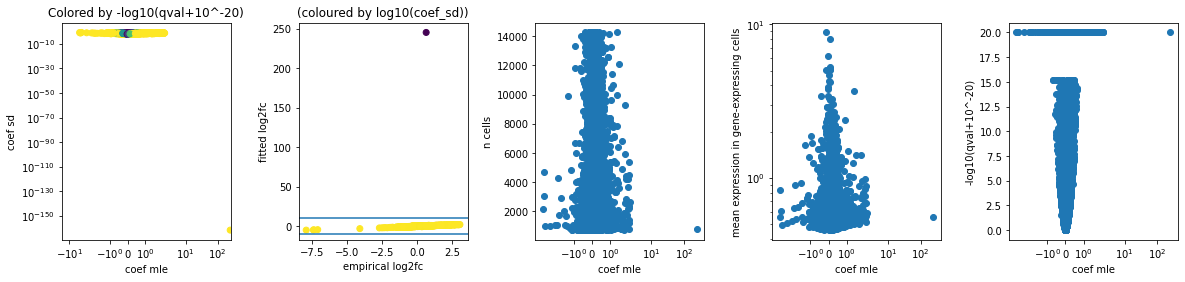

Min coef_sd: 2.2227587494850775e-162


In [22]:
# Plot diagramms for coef sd over coef mle,  fitted log2fc over empirical log3fc, 
# n cells over coef mle,  mean expr in gene_epxr cells over coef mle,  
# -log10(qval+10^-20) over coef mle,
# to see if we need to filter the results/summary for to small coef sd

fig,ax=plt.subplots(1,5,figsize=(20,4))
plt.subplots_adjust(wspace=0.4)

ax[0].scatter(summary.coef_mle,summary.coef_sd,c=-np.log10(summary.qval+10**-20))
ax[0].set_xlabel('coef mle')
ax[0].set_ylabel('coef sd')
ax[0].set_yscale('log')
ax[0].set_xscale('symlog')
ax[0].set_title('Colored by -log10(qval+10^-20)')

ax[4].scatter(summary.coef_mle,-np.log10(summary.qval+10**(-20)))
ax[4].set_xlabel('coef mle')
ax[4].set_ylabel('-log10(qval+10^-20)')
ax[4].set_xscale('symlog')

if 'empirical_log2fc' in dir(result):
    ax[1].set_title('(coloured by log10(coef_sd))')
    # genes with nan empirical lfc will not be shown
    ax[1].scatter(x=result.empirical_log2fc.values,y=summary.log2fc,
                c=np.log10(summary.coef_sd))
    ax[1].set_xlabel('empirical log2fc')
    ax[1].set_ylabel('fitted log2fc')
    #ax[1].set_yscale('symlog')
    ax[1].axhline(10)
    ax[1].axhline(-10)

ax[2].scatter(summary.coef_mle,n_cells[summary.gene])
ax[2].set_xlabel('coef mle')
ax[2].set_ylabel('n cells')
ax[2].set_xscale('symlog')

ax[3].scatter(summary.coef_mle,mean_expr_in_expr_cells[summary.gene])
ax[3].set_xlabel('coef mle')
ax[3].set_ylabel('mean expression in gene-expressing cells')
ax[3].set_xscale('symlog')
ax[3].set_yscale('log')

display(fig)
plt.close()
print('Min coef_sd:',summary.coef_sd.min())

C: Some genes could not be fitted - seen from the extremely small coef SD (technical issue).

In [23]:
# Filter result/summary to remove those with too small sd
if 'empirical_log2fc' in dir(result):
    result.empirical_log2fc=result.empirical_log2fc[
        summary.coef_sd>2.2227587494850775e-162]
summary = summary[summary.coef_sd>2.2227587494850775e-162]

Replot result vs gene characteristics after filtering out genes that could not be fitted.

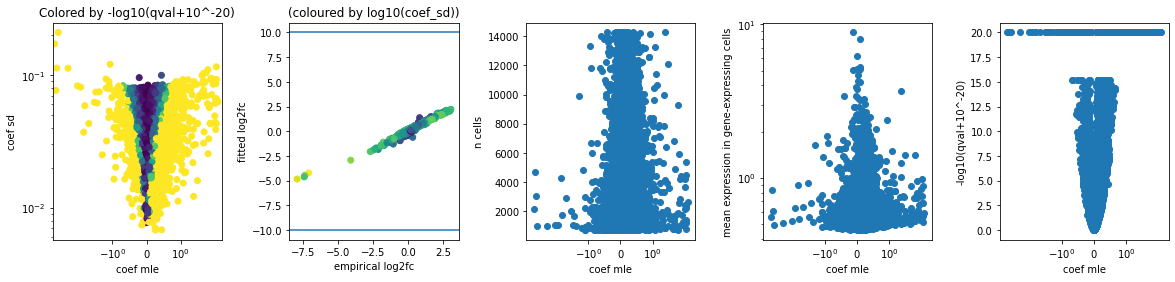

Min coef_sd: 0.006801054546742528


In [24]:
# Plot 5 different diagramms for, coef sd over coef mle,  fitted log2fc over empirical log3fc, n cells over coef mle,  mean expr in gene_epxr cells over coef mle,  -log10(qval+10^-20) over coef mle,
# to see if the filtering was successfull and we can advance 

fig,ax=plt.subplots(1,5,figsize=(20,4))
plt.subplots_adjust(wspace=0.4)

ax[0].scatter(summary.coef_mle,summary.coef_sd,c=-np.log10(summary.qval+10**-20))
ax[0].set_xlabel('coef mle')
ax[0].set_ylabel('coef sd')
ax[0].set_yscale('log')
ax[0].set_xscale('symlog')
ax[0].set_title('Colored by -log10(qval+10^-20)')

ax[4].scatter(summary.coef_mle,-np.log10(summary.qval+10**(-20)))
ax[4].set_xlabel('coef mle')
ax[4].set_ylabel('-log10(qval+10^-20)')
ax[4].set_xscale('symlog')

if 'empirical_log2fc' in dir(result):
    ax[1].set_title('(coloured by log10(coef_sd))')
    # genes with nan empirical lfc will not be shown
    ax[1].scatter(x=result.empirical_log2fc.values,y=summary.log2fc,
                c=np.log10(summary.coef_sd))
    ax[1].set_xlabel('empirical log2fc')
    ax[1].set_ylabel('fitted log2fc')
    #ax[1].set_yscale('symlog')
    ax[1].axhline(10)
    ax[1].axhline(-10)

ax[2].scatter(summary.coef_mle,n_cells[summary.gene])
ax[2].set_xlabel('coef mle')
ax[2].set_ylabel('n cells')
ax[2].set_xscale('symlog')

ax[3].scatter(summary.coef_mle,mean_expr_in_expr_cells[summary.gene])
ax[3].set_xlabel('coef mle')
ax[3].set_ylabel('mean expression in gene-expressing cells')
ax[3].set_xscale('symlog')
ax[3].set_yscale('log')

display(fig)
plt.close()
print('Min coef_sd:',summary.coef_sd.min())

Add gene symbols as index

In [25]:
# give summary an index with the gene_symbols
summary['EID']=summary.index
summary.index=adata_b_rn_sub.var.loc[summary.index,'gene_symbol']

In [26]:
# Save summary table for sharing
if True:
    summary.to_csv(
        path_de+'maleFemale_Fltp_2y_'+str(min_cells_ratio)+'_summary_sdFiltered.tsv',
    sep='\t',index=False)

### Check top genes

In [ ]:
# The top/bottom DE genes
nAnz = 10
# Get the top 10 Genes, and save then in summary_abs_top10
summary_abs_topnAnz = summary.coef_mle.sort_values(ascending=False)[0:nAnz]
# Get the bottom 10 Genes, and save then in summary_abs_bottom10
summary_abs_bottomnAnz = summary.coef_mle.sort_values(ascending=True)[0:nAnz]

# Get the Top/bottom 10 Genes in a list
genes_top = summary_abs_topnAnz.index.tolist()
genes_bottom = summary_abs_bottomnAnz.index.tolist()

In [28]:
# Print out the top DE genes to see all data for them:
summary.loc[genes_top,:]

gene  pval  qval    log2fc      mean  zero_mean  \
gene_symbol                                                                  
Tsix         ENSMUSG00000085715   0.0   0.0  2.224512  0.242686      False   
Kcnk9        ENSMUSG00000036760   0.0   0.0  2.122722  0.464604      False   
Lrrc8c       ENSMUSG00000054720   0.0   0.0  2.113864  0.108468      False   
Hcn1         ENSMUSG00000021730   0.0   0.0  2.103845  0.207044      False   
Kirrel3      ENSMUSG00000032036   0.0   0.0  2.102246  0.064548      False   
Neb          ENSMUSG00000026950   0.0   0.0  2.095687  0.549498      False   
Prok1        ENSMUSG00000070368   0.0   0.0  2.072678  0.111064      False   
Crispld2     ENSMUSG00000031825   0.0   0.0  2.053049  1.228583      False   
Fbxw24       ENSMUSG00000062275   0.0   0.0  2.029973  0.188311      False   
Cldn8        ENSMUSG00000050520   0.0   0.0  2.027936  0.388339      False   

                     grad  coef_mle   coef_sd            ll  \
gene_symbol                                                   
Tsix         3.206572e-08  2.224512  0.062734  -8260.351039   
Kcnk9        9.095039e-08  2.122722  0.065274 -10288.101171   
Lrrc8c       5.760441e-08  2.113864  0.092515  -4702.624344   
Hcn1         1.606759e-07  2.103845  0.066260  -7334.873874   
Kirrel3      8.290713e-08  2.102246  0.115231  -3234.240434   
Neb          1.121711e-08  2.095687  0.043092 -12976.976086   
Prok1        4.150568e-08  2.072678  0.085925  -4892.272334   
Crispld2     1.398211e-07  2.053049  0.038902 -19179.681807   
Fbxw24       4.719643e-07  2.029973  0.066400  -6899.680999   
Cldn8        3.464093e-09  2.027936  0.061257  -9618.775640   

                            EID  
gene_symbol                      
Tsix         ENSMUSG00000085715  
Kcnk9        ENSMUSG00000036760  
Lrrc8c       ENSMUSG00000054720  
Hcn1         ENSMUSG00000021730  
Kirrel3      ENSMUSG00000032036  
Neb          ENSMUSG00000026950  
Prok1        ENSMUSG00000070368  
Crispld2     ENSMUSG00000031825  
Fbxw24       ENSMUSG00000062275  
Cldn8        ENSMUSG00000050520

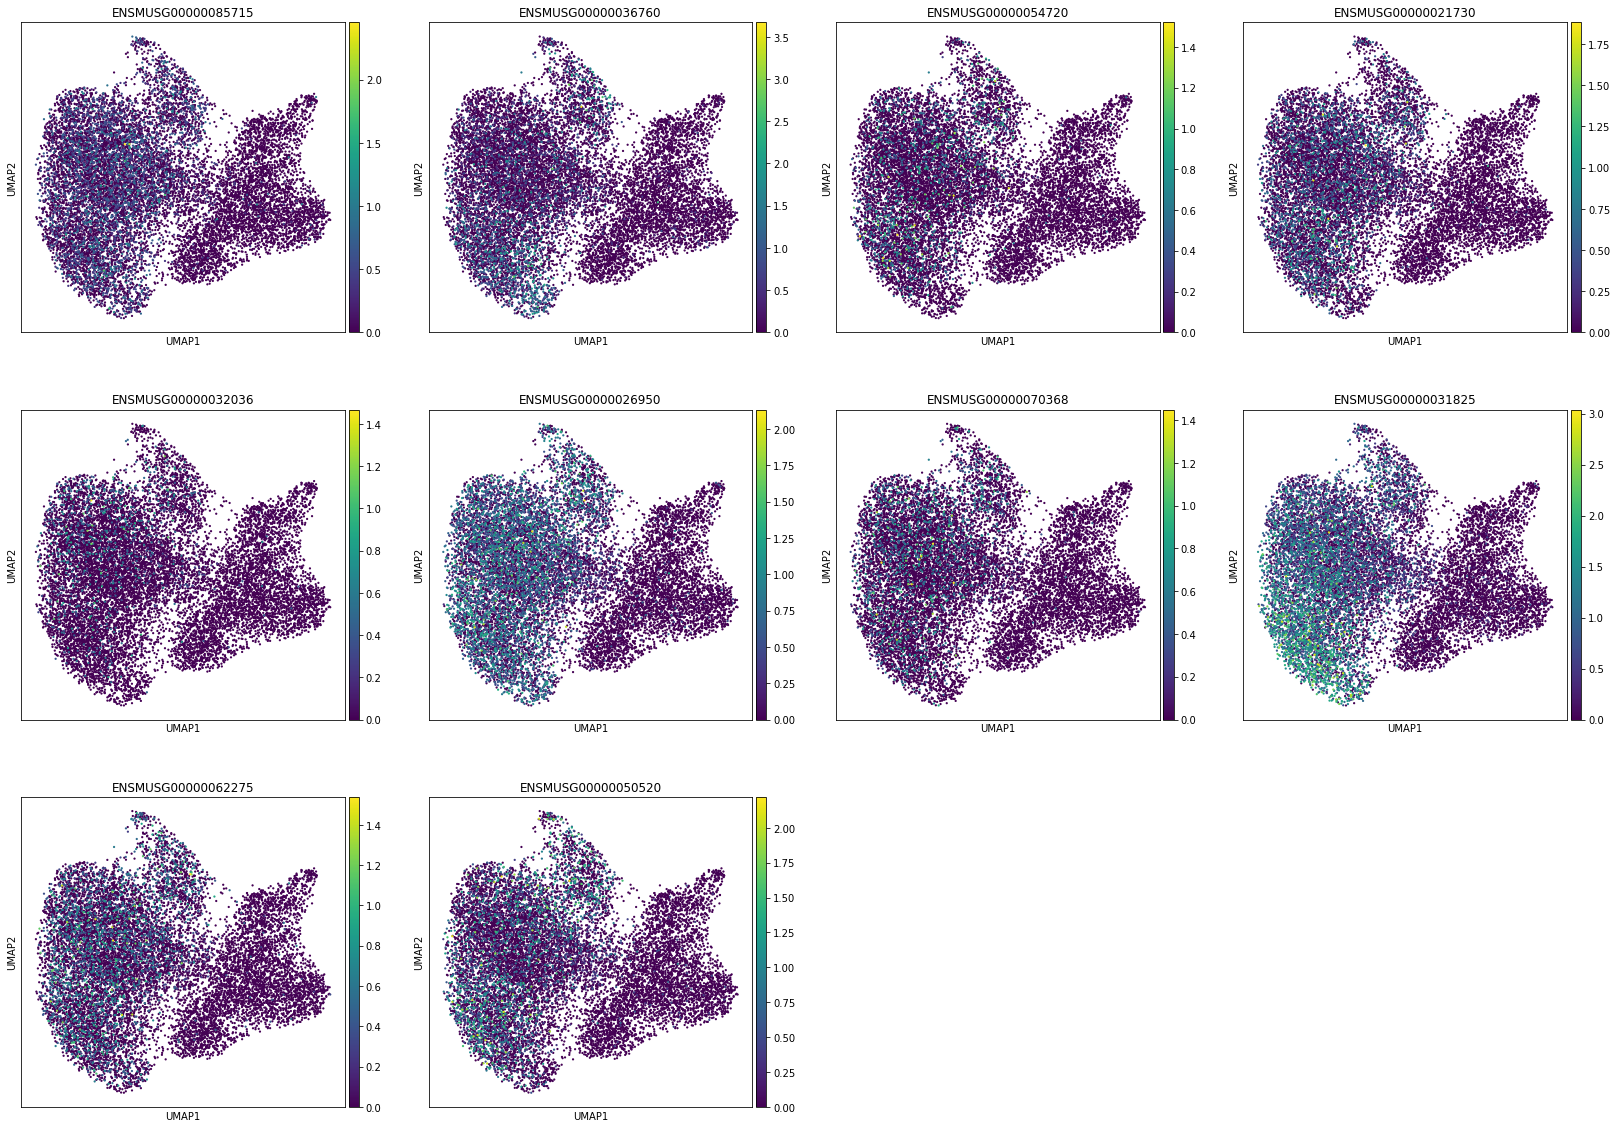

In [29]:
# Plot genes with  strongest lfc
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_b_rn_sub,
           color=summary.sort_values(
               ['coef_mle'],ascending=[False]).gene[:nAnz],
           s=20)

In [30]:
# Print out the bottom DE genes to see all data for them:
summary.loc[genes_bottom,:]

gene  pval  qval    log2fc      mean  zero_mean  \
gene_symbol                                                                  
Uty          ENSMUSG00000068457   0.0   0.0 -4.836295  0.210903      False   
Ddx3y        ENSMUSG00000069045   0.0   0.0 -4.614317  0.830632      False   
Eif2s3y      ENSMUSG00000069049   0.0   0.0 -4.457617  0.336210      False   
Kdm5d        ENSMUSG00000056673   0.0   0.0 -4.215118  0.080544      False   
BC023719     ENSMUSG00000092365   0.0   0.0 -2.923149  0.089315      False   
Reln         ENSMUSG00000042453   0.0   0.0 -2.054227  0.093735      False   
Aldh1a3      ENSMUSG00000015134   0.0   0.0 -1.927818  0.138287      False   
Pappa2       ENSMUSG00000073530   0.0   0.0 -1.839096  0.993615      False   
Pcdh15       ENSMUSG00000052613   0.0   0.0 -1.805785  0.164527      False   
Gc           ENSMUSG00000035540   0.0   0.0 -1.689416  0.367431      False   

                     grad  coef_mle   coef_sd            ll  \
gene_symbol                                                   
Uty          6.428051e-07 -4.836295  0.171556  -5802.862840   
Ddx3y        1.953345e-07 -4.614317  0.076476 -11178.719338   
Eif2s3y      1.886995e-07 -4.457617  0.112618  -7505.317523   
Kdm5d        5.773674e-08 -4.215118  0.208951  -3263.450826   
BC023719     1.401140e-08 -2.923149  0.112455  -3569.769101   
Reln         1.637664e-07 -2.054227  0.082797  -3948.358835   
Aldh1a3      1.236773e-08 -1.927818  0.080983  -4605.598161   
Pappa2       2.472362e-07 -1.839096  0.037091 -15684.485458   
Pcdh15       3.628674e-08 -1.805785  0.058725  -5994.007399   
Gc           2.566115e-07 -1.689416  0.043115  -9633.227331   

                            EID  
gene_symbol                      
Uty          ENSMUSG00000068457  
Ddx3y        ENSMUSG00000069045  
Eif2s3y      ENSMUSG00000069049  
Kdm5d        ENSMUSG00000056673  
BC023719     ENSMUSG00000092365  
Reln         ENSMUSG00000042453  
Aldh1a3      ENSMUSG00000015134  
Pappa2       ENSMUSG00000073530  
Pcdh15       ENSMUSG00000052613  
Gc           ENSMUSG00000035540

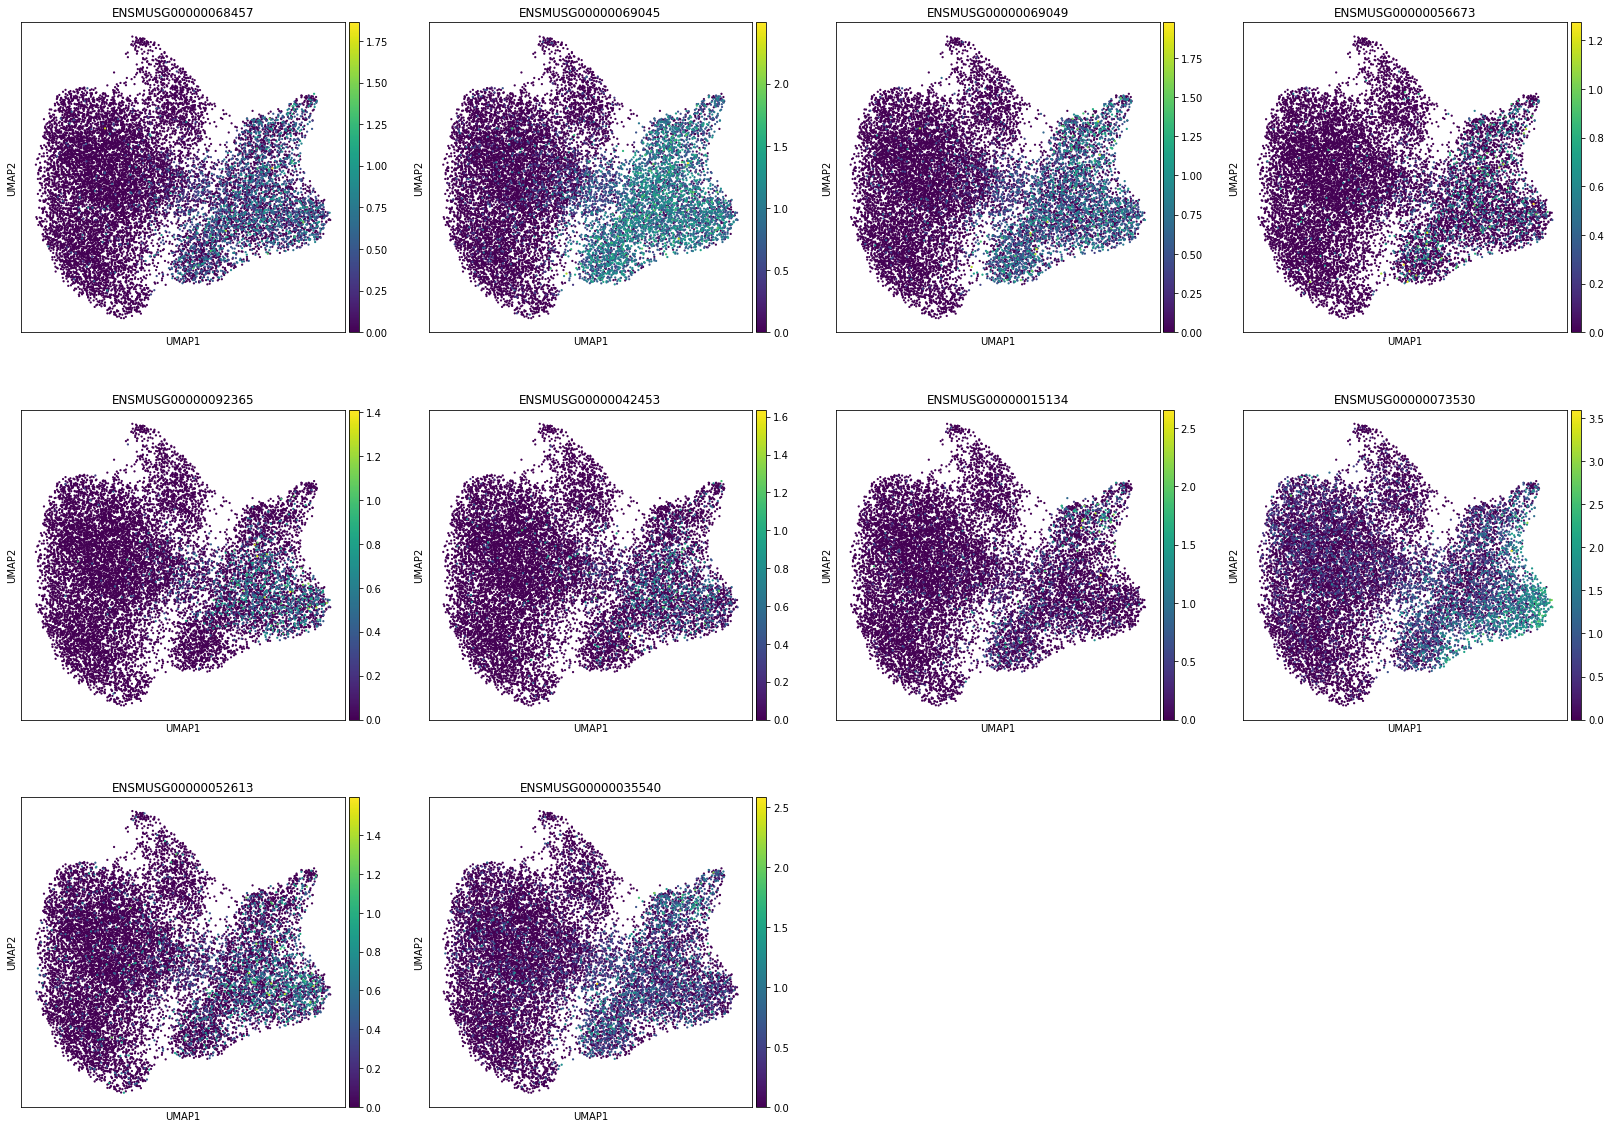

In [31]:
# Plot genes with  strongest negative lfc
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_b_rn_sub,
           color=summary.sort_values(['coef_mle']).gene[:nAnz],
           s=20)

### N DE genes at different filtering thresholds

In [34]:
# Try different thresholds for FDR and ALFC to see how many genes are retained
for fdr,lfc in [(0.05,1),(0.05,0.5),(0.05,0.3),
                (0.025,1),(0.025,0.5), (0.025,0.3)]:
    print('fdr %.2e, abs(lfc) > %.1f up %i down %i'%
          (fdr,lfc,summary.query('qval<@fdr & log2fc>@lfc').shape[0],
           summary.query('qval<@fdr & log2fc<-@lfc').shape[0]))

fdr 5.00e-02, abs(lfc) > 1.0 up 116 down 26
fdr 5.00e-02, abs(lfc) > 0.5 up 520 down 107
fdr 5.00e-02, abs(lfc) > 0.3 up 1921 down 268
fdr 2.50e-02, abs(lfc) > 1.0 up 116 down 26
fdr 2.50e-02, abs(lfc) > 0.5 up 520 down 107
fdr 2.50e-02, abs(lfc) > 0.3 up 1921 down 268


Text(0.5, 0, 'log2fc')

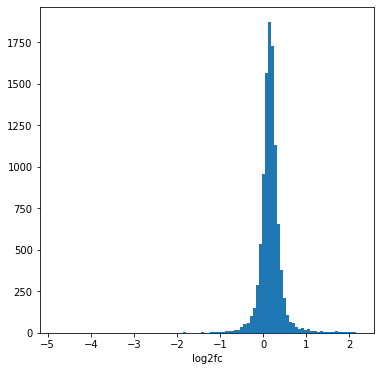

In [35]:
# Plot the distribution for log2fc
plt.hist(summary.log2fc,bins=100)
plt.xlabel('log2fc')